In [19]:
import stl
from stl import mesh
import numpy as np
from scipy.optimize import minimize
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

In [2]:
your_mesh0 = mesh.Mesh.from_file("square.stl")
your_mesh1 = mesh.Mesh.from_file("rectangle.stl")

In [42]:
def to2Dlize(your_mesh0):
    mesh2D0=np.zeros([len(your_mesh0[:,0]),6])
    for i in range(len(your_mesh0)):
        mesh2D0[i,0]=your_mesh0[i,0]
        mesh2D0[i,1]=your_mesh0[i,1]
        mesh2D0[i,2]=your_mesh0[i,3]
        mesh2D0[i,3]=your_mesh0[i,4]
        mesh2D0[i,4]=your_mesh0[i,6]
        mesh2D0[i,5]=your_mesh0[i,7]
    return mesh2D0

mesh2d0=to2Dlize(your_mesh0)
mesh2d1=to2Dlize(your_mesh1)

def rescale(a,b,t):
    return a+(b-a)*t

def isintriangle(triangle,point):
    def sign(p1,p2,p3):
        return (p1[0] - p3[0]) * (p2[0] - p3[0]) - (p2[0] - p3[0]) * (p1[0] - p3[0]);
    
    d1=sign(point,triangle[0],triangle[1])
    d2=sign(point,triangle[1],triangle[2])
    d3=sign(point,triangle[2],triangle[0])
    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0);
    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0);
    
    return not(has_neg and has_pos)

def isinmesh(point,mesh):
    mesh=np.reshape(mesh,(mesh.shape[0],3,2))
    for i in range(mesh.shape[0]):
        if isintriangle(mesh[i],point):
            return True
    return False



def sample(mesh,npoints):
    ###Find a square containing it
    xmax=-np.inf
    ymax=-np.inf
    xmin=np.inf
    ymin=np.inf
    for i in range(len(mesh)):
        xmaxtemp=np.max(mesh[i,0::2])
        xmintemp=np.min(mesh[i,0::2])
        if xmaxtemp>=xmax:
            xmax=xmaxtemp
        if xmintemp<=xmin:
            xmin=xmintemp
        ymaxtemp=np.max(mesh[i,1::2])
        ymintemp=np.min(mesh[i,1::2])

        if ymaxtemp>=ymax:
            ymax=ymaxtemp
        if ymintemp<=ymin:
            ymin=ymintemp

        
    points=np.zeros([npoints,2])
    k=0
    h=0
    #####Add points inside the mesh to a vector
    while k<npoints:
        h=h+1;
        point=np.array([rescale(xmin,xmax,np.random.rand()),rescale(ymin,ymax,np.random.rand())])
        if (isinmesh(point,mesh)):
            points[k]=point
            k=k+1
    areasquare=np.linalg.norm(xmax-xmin)*np.linalg.norm(ymax-xmin)
    ###MCMC integration
    area=areasquare*k/h
    return points,area

M1num,_=sample(mesh2d1,100)
M0num,area0=sample(mesh2d0,1000)
v=(area0/M1num.shape[0])*np.ones(M1num.shape[0])
w=np.zeros(M1num.shape[0])

def computeVoronoi(M0num,M1num,w):
    Vor=np.zeros(M0num.shape[0])
    for i in range(M0num.shape[0]):
        Vor[i]=int(np.argmin(np.array([np.linalg.norm(M0num[i]-M1num[j])**2-w[j] for j in range(M1num.shape[0])])))
    return Vor  

def centroids(M0num,M1num,w):
    V=computeVoronoi(M0num,M1num,w).astype(int)
    print(np.max(V))
    centroid=np.zeros([M1num.shape[0],2])
    counter=np.zeros(M1num.shape[0])
    for j in range(M0num.shape[0]):
        centroid[V[j]]=centroid[V[j]]+M0num[j]
        counter[V[j]]=counter[V[j]]+1
    print(counter)
    for j in range(M1num.shape[0]): 
        if counter[j]!=0:
            centroid[j]=centroid[j]/counter[j]
            print(centroid[j])
    return centroid

def G(w,M0num,M1num,v,area0):
    Vor=computeVoronoi(M0num,M1num,w)   
    for i in range(M1num.shape[0]):
        temp1=0
        temp=0
        h=0
        for j in range(M0num.shape[0]):
            if Vor[j]==i:
                temp=temp+np.linalg.norm(M1num[i]-M0num[j])**2
                h=h+1;
        area=area0*h/M0num.shape[0]
        temp=temp*(area)/h-w[i]*area+w[i]*v[i]
        temp1=temp1+temp
    return temp

def deltaG(w,M0num,M1num,v,area0):
    Vor=computeVoronoi(M0num,M1num,w)
    hello=[]
    for i in range(M1num.shape[0]):
        h=0
        for j in range(M0num.shape[0]):
            if Vor[j]==i:
                h=h+1;
            area=area0*h/M0num.shape[0]
        hello.append(area+v[i])
    return hello

fG=lambda w: G(w,M0num,M1num,v,area0)
fdeltaG=lambda w: deltaG(w,M0num,M1num,v,area0)
'''
print("start optimizing")
wopt = minimize(fG, w, method='BFGS', jac=fdeltaG,
               options={'gtol': 1e-6, 'disp': True})
'''


'\nprint("start optimizing")\nwopt = minimize(fG, w, method=\'BFGS\', jac=fdeltaG,\n               options={\'gtol\': 1e-6, \'disp\': True})\n'

99
[ 24.   0.   0.  25.  22.   2.   0.  16.   0.   0.  12.   3.   0.  14.
   0. 112. 132.   0.  14.   0.   0.   0.  43.   0.   0.  21.   0.   0.
   0.   0.  23.   0.  14.   0.   0.   0.   2.   3.   0.   0.   2.  53.
   0.   2.   0.   0.   0.  13.  94.   0.   0.   0.   3.   0.  18.   3.
  22.  34.   0. 139.  18.   7.  21.   0.  23.   0.   0.   0.   0.   0.
   0.   6.   0.   0.   0.   0.  27.   0.   0.   0.   0.   9.   0.   0.
   5.  12.   0.   0.   5.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   2.]
[0.44356382 0.3970329 ]
[0.57243198 0.21248253]
[0.6823677  0.33107143]
[0.39410948 0.12885001]
[0.91863557 0.32987488]
[0.11228795 0.19309466]
[0.8416428  0.03409294]
[0.18743602 0.32119668]
[0.19769671 0.75309592]
[0.87534526 0.72126988]
[0.21325747 0.23066246]
[0.26485486 0.09307002]
[0.94889267 0.18914822]
[0.65257388 0.42942392]
[0.60605463 0.10321721]
[0.59764845 0.01409006]
[0.98933582 0.35502029]
[0.51491178 0.30051563]
[0.05462107 0.64578897]
[0.99705185 0.48594397]
[0.97504

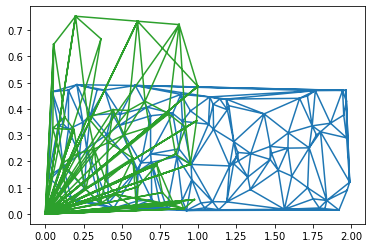

In [44]:
from scipy.spatial import Delaunay
w=wopt.x
centroid=centroids(M0num,M1num,w)
tri=Delaunay(M1num)
plt.triplot(M1num[:,0], M1num[:,1], tri.simplices)
plt.triplot(centroid[:,0], centroid[:,1], tri.simplices)


In [28]:
np.min(M0num)

4.7231081384269125e-05

<IPython.core.display.Javascript object>


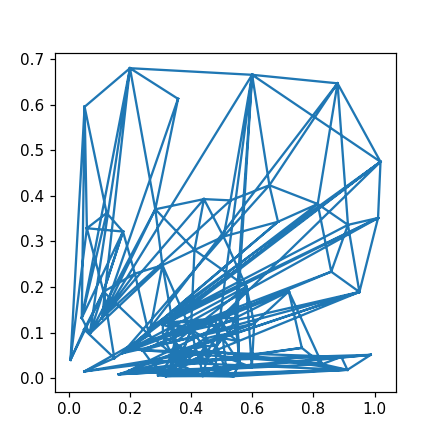

In [83]:
%matplotlib notebook
import matplotlib.animation as animation

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))


def update(frame):
    ax.clear()
    ax.triplot(frame/100*M1num[:,0]+(1-frame/100)*centroid[:,0],frame/100*M1num[:,1]+(1-frame/100)*centroid[:,1], tri.simplices)
    
    
ani = animation.FuncAnimation(fig,update,range(100), blit = False)


<IPython.core.display.Javascript object>


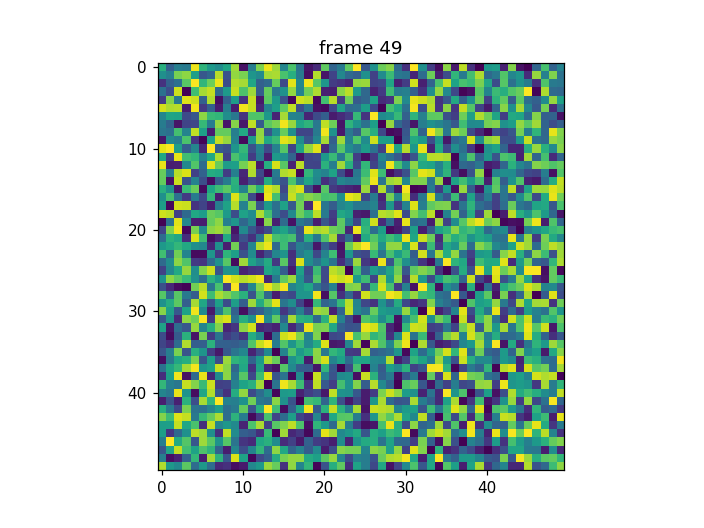